# 1. Import Dependencies

In [1]:
import gym
gym.logger.set_level(40)
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os

import tkinter as Tk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import datetime as dt

In [2]:
from numpy import arange, sin, pi
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

# 2. Building an Environment

In [3]:
class HVACEnv(Env):
    def __init__(self):
        # Actions we can take, HVACon, HVACoff, stay
        self.action_space = Discrete(3)
        # Temperature array
        self.observation_space = Box(low=np.array([15]), high=np.array([30]),shape=(1,), dtype=np.float32)
        # Set start temp
        self.state = 24 + random.randint(-3,3)
        # Set HVAC length
        self.HVAC_episode = 60
        self.action = 0
        
    def step(self, action):
        
        # Apply action
        # 0 -1 = -1 reduce pump speed reduced temp
        # 1 -1 = 0 
        # 2 -1 = 1 increase pump speed increase temp
        self.state += action -1 
        # Decrement step
        self.HVAC_episode -= 1 
        
        # Calculate reward
        if self.state >=22 and self.state <=26: 
            reward =1 
        else:
            reward = -1
        
        # Check if episode is done 
        if self.HVAC_episode <= 0: 
            done = True
        else:
            done = False
        
        # Apply HVAC temperature noise
        self.state += random.randint(-1,1)
        # Set placeholder for info
        info = {}
        
        
        # Return step information
        return self.state, reward, done, info

    def render(self,mode='human'):
        root = Tk.Tk()
        fig = plt.Figure(figsize=(12, 5), dpi=100)
        a = fig.add_subplot(111)
        
                
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.get_tk_widget().grid(column=0,row=1)
        xList = []
        yList = []
        
        l4 = Tk.Label(root, text = "Starting Temp",bg='blue',font=('helvetica', 11, 'bold'))
        l4.grid(row = 1, column = 10, pady = 1)
        l4 = Tk.Label(root, text = self.state)
        l4.grid(row = 1, column = 11, pady = 1)
        
        
        button1=Tk.Button(root, text='Reset', command=env.reset(), bg='blue', font=('helvetica', 11, 'bold'))
        button1.grid(row=2,column=13,pady=3)

        def animate(i,xList,yList):
            xList.append(dt.datetime.now().strftime('%H:%M:%S'))        
            yList.append(self.state)
            xList = xList[-20:]
            yList = yList[-20:]
            a.clear()
            a.plot(xList, yList,label='State(Room Temp)')
            a.set_title("HVAC Room Temp Control")
            a.set_xlabel("Time")
            a.set_ylabel("Room Temperature")
            a.legend()
            plt.xticks(rotation=45, ha='left')
            plt.subplots_adjust(bottom=0.80)

        ani = animation.FuncAnimation(fig, animate, fargs=(xList,yList), interval=500, blit=False)
        Tk.mainloop()
    
    
    def reset(self):
        
        # Reset HVAC temperature
        self.state = 24 + random.randint(-4,4)
        
        # Reset episode to one minute cal
        self.HVAC_episode = 60
        
        return self.state
    

In [4]:
env=HVACEnv()

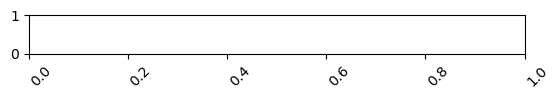

In [5]:
#env = make_vec_env(HVACEnv, n_envs=1)
env.render()

# 4. Test Environment

In [6]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
print('Episode:{} Score:{} State:{}'.format(episode, score, state))
#env.render(action,state)
env.close()

Episode:10 Score:-58 State:23


# 5. Train Model

In [7]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import *

In [8]:
log_path = os.path.join('Training', 'Logs')

In [9]:
env = make_vec_env(HVACEnv, n_envs=1)
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [6]:
model.learn(total_timesteps=100000) #1M Steps, 490 Iterations,

Logging to Training\Logs\PPO_13
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    fps             | 415      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60          |
|    ep_rew_mean          | -20.8       |
| time/                   |             |
|    fps                  | 601         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007289117 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000101   

# 6. Save Model

In [10]:
HVAC_path = os.path.join('HVACtraining', 'Saved Models', 'HVAC_Model_PPO')

In [5]:
model.save(HVAC_path)

NameError: name 'model' is not defined

In [ ]:
del model

In [11]:
env = make_vec_env(HVACEnv, n_envs=1)
model = PPO.load(HVAC_path,env)

In [ ]:
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

In [ ]:
env.close()